# **Fine-Tuning:**
Fine-Tuning is taking a pre-trained model and training at least one internal model parameterin order to make it better suited for a given task. There are generally three steps.

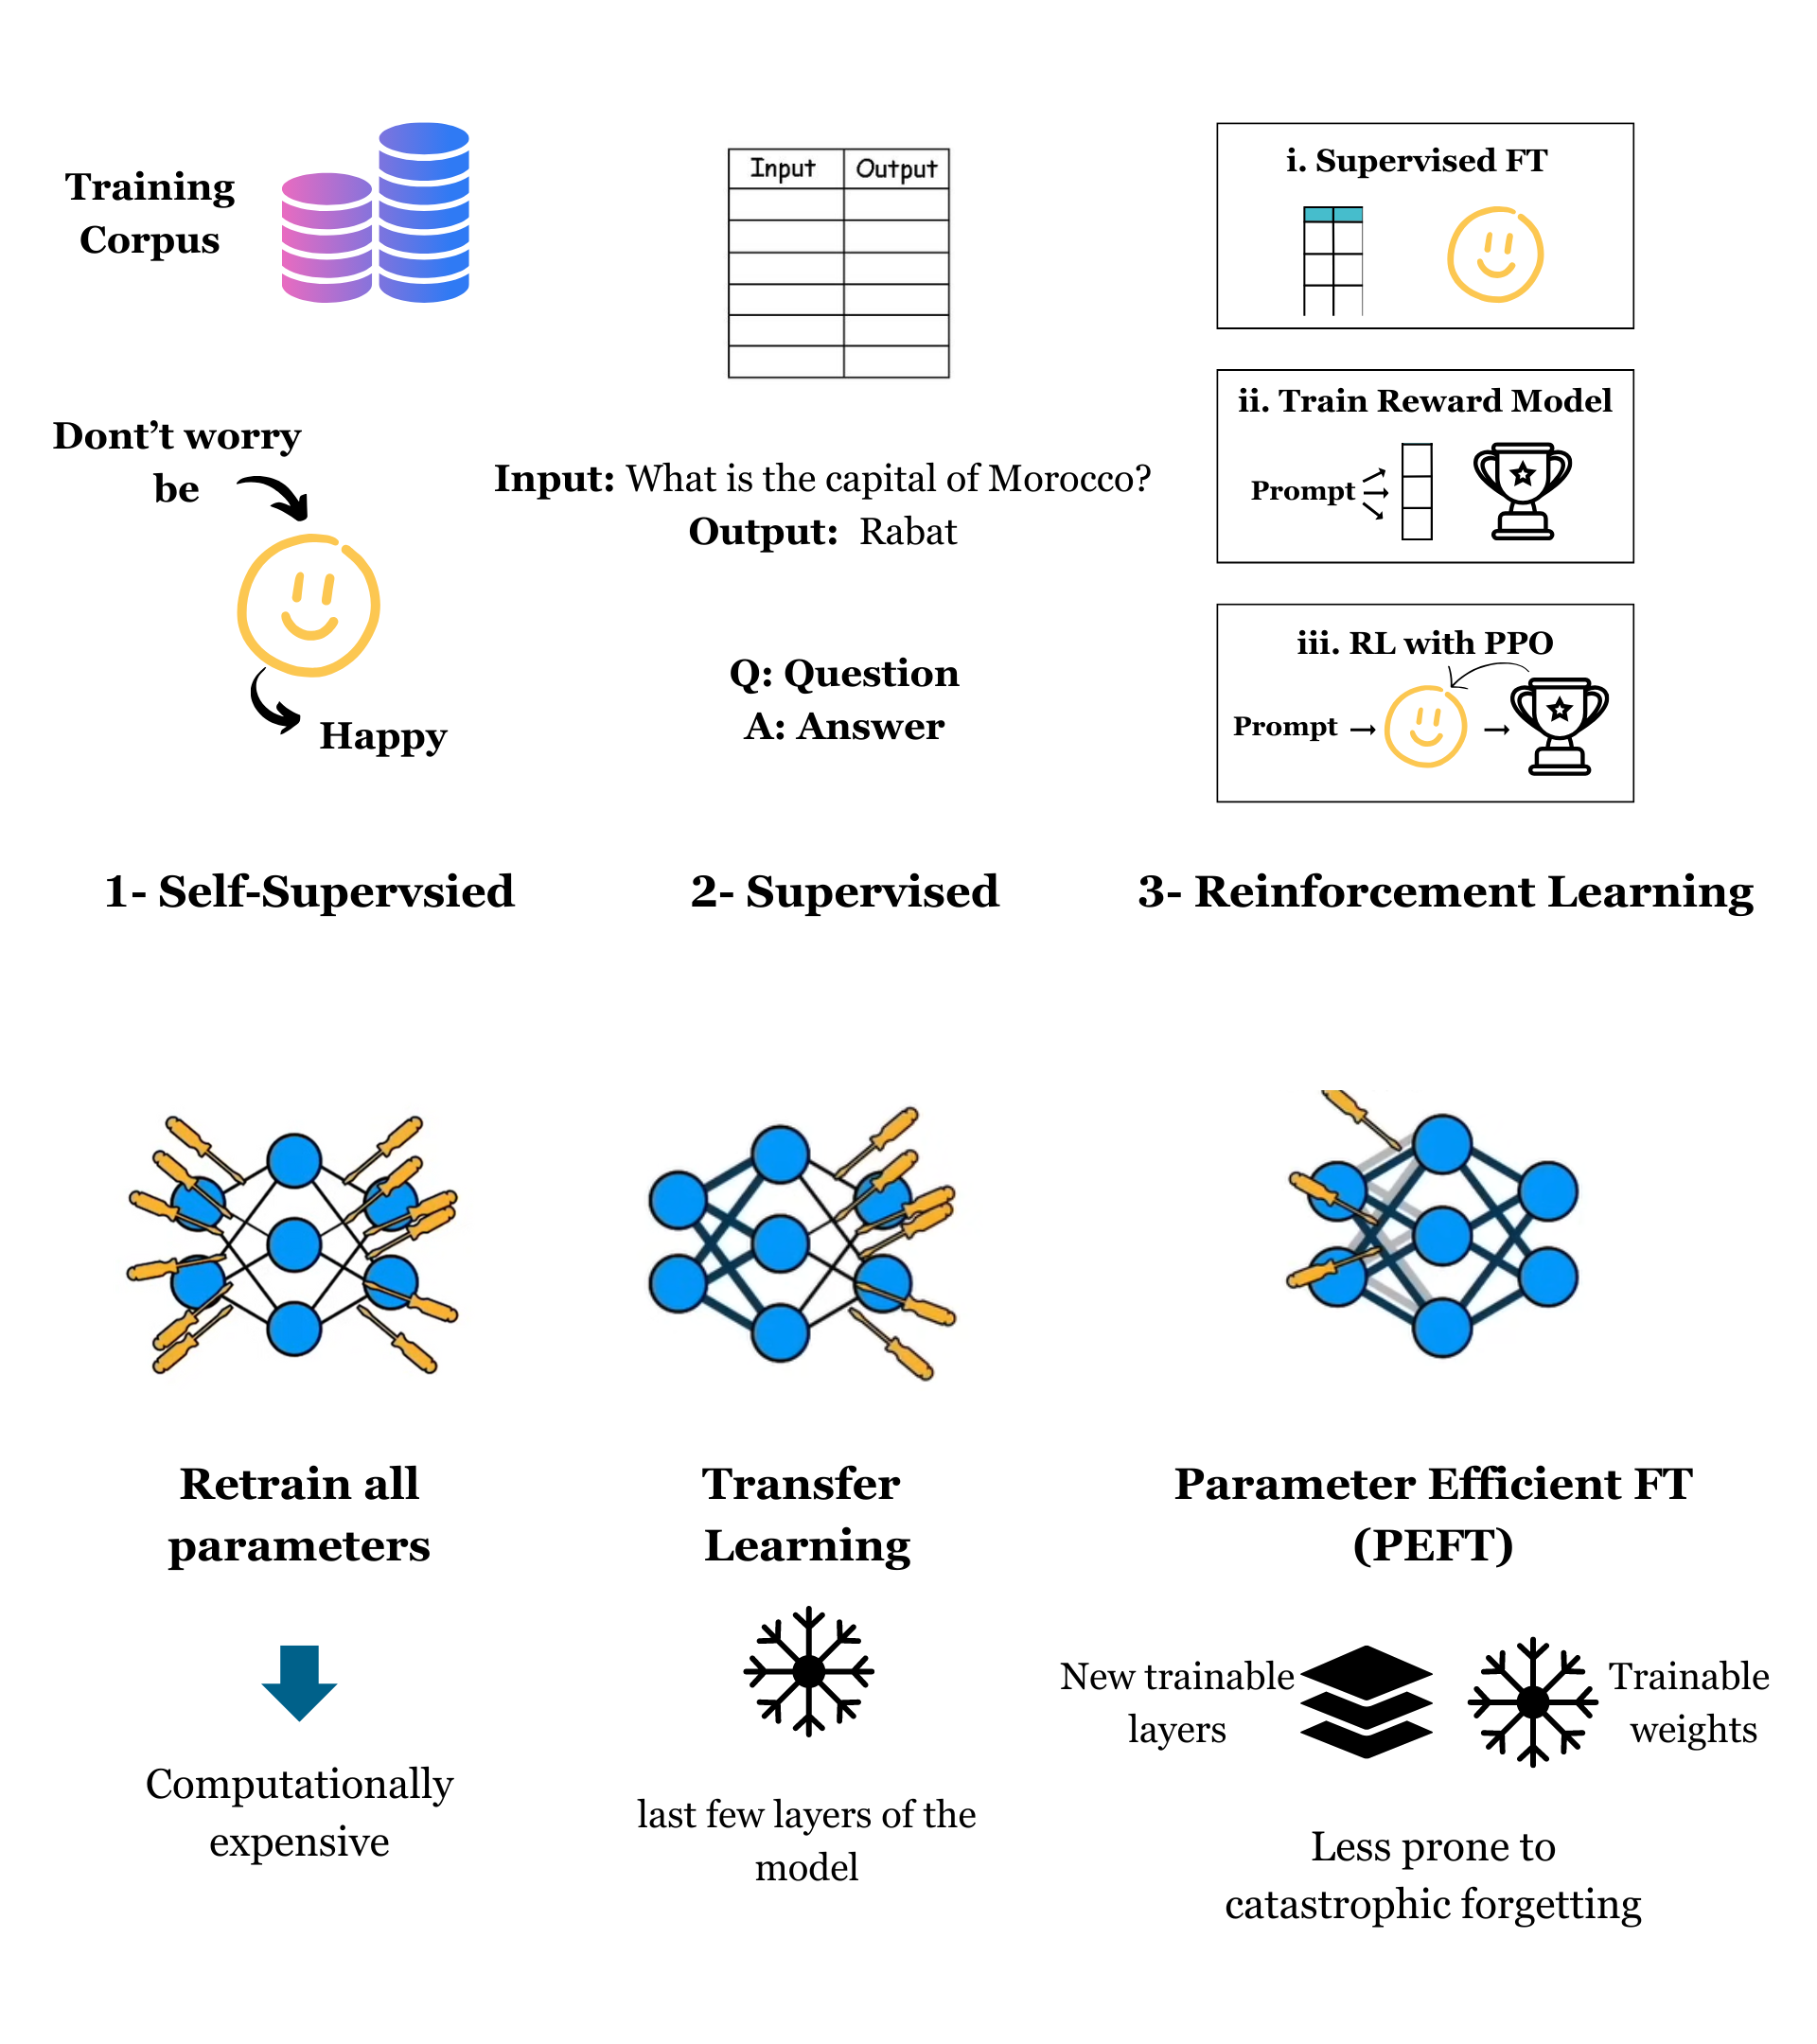


## Supervised Fine-Tuning:


1.   We choose a fine tuning task
2.   We prepare our training dataset
3.   We choose a base model
4.   We fine-tune the model via SFT
5.   We evaluate the model performance



## **Example Code using LoRA (Low-Rank Adaptation approach)**

In [ ]:
!pip install datasets
!pip install transformers
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 97.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.0
    Uninstalling huggingface-hub-0.19.0:
      Successfully uninstalled huggingface-hub-0.19.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
!pip install peft
!pip install torch
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.7 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np

### dataset

In [ ]:
# load dataset
dataset = load_dataset("shawhin/imdb-truncated")
dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
})

In [ ]:
# display % of training data with label=1
np.array(dataset['train']['label']).sum()/len(dataset['train']['label'])

0.5

### model

In [ ]:
model_checkpoint = 'distilbert-base-uncased'

# define label maps
id2label = {0: "Negative", 1: "Positive"}
label2id = {"Negative":0, "Positive":1}

# generate classification model from model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# display architecture
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### preprocess data

In [ ]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

In [ ]:
# create tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["text"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs

In [ ]:
# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
})

In [ ]:
# create data collator to dynamically pad examples in a given batch to be as long as the longest sequence in that batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### evaluation

In [ ]:
# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

In [ ]:
# define an evaluation function to pass into trainer later
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

### Apply untrained model to text

In [ ]:
# define list of examples
text_list = ["It was good.", "Not a fan, don't recommed.", "Better than the first one.", "This is not worth watching even once.", "This one is a pass."]

print("Untrained model predictions:")
print("----------------------------")
for text in text_list:
    # tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt")
    # compute logits
    logits = model(inputs).logits
    # convert logits to label
    predictions = torch.argmax(logits)

    print(text + " - " + id2label[predictions.tolist()])

Untrained model predictions:
----------------------------
It was good. - Positive
Not a fan, don't recommed. - Positive
Better than the first one. - Positive
This is not worth watching even once. - Positive
This one is a pass. - Positive


### Train model

In [ ]:
peft_config = LoraConfig(task_type="SEQ_CLS", # sequence classification
                        r=4, # rank of trainable weight matrix
                        lora_alpha=32, # a parameter like learning rate
                        lora_dropout=0.01, # probability of dropout
                        target_modules = ['q_lin']) # we apply lora to query layer

In [ ]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules={'q_lin'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={})

In [ ]:
# another model ready to be fine tuned
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 628,994 || all params: 67,584,004 || trainable%: 0.9306847223789819


In [ ]:
# hyperparameters
lr = 1e-3 # size of optimization step
batch_size = 4
num_epochs = 10

In [ ]:
pip install accelerate -U

In [ ]:
pip install transformers[torch]

In [ ]:
# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
# creater trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics,
)

# train model
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.340002,{'accuracy': 0.879}
2,0.444900,0.441341,{'accuracy': 0.881}
3,0.444900,0.464942,{'accuracy': 0.88}
4,0.219300,0.644981,{'accuracy': 0.873}
5,0.219300,0.862436,{'accuracy': 0.882}
6,0.077300,0.824696,{'accuracy': 0.889}
7,0.077300,0.817318,{'accuracy': 0.888}
8,0.032500,0.842063,{'accuracy': 0.893}
9,0.032500,0.913277,{'accuracy': 0.893}
10,0.009300,0.919823,{'accuracy': 0.897}


Trainer is attempting to log a value of "{'accuracy': 0.879}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.881}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.88}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.873}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.882}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This in

TrainOutput(global_step=2500, training_loss=0.15666928882598877, metrics={'train_runtime': 28458.3136, 'train_samples_per_second': 0.351, 'train_steps_per_second': 0.088, 'total_flos': 1106579668322304.0, 'train_loss': 0.15666928882598877, 'epoch': 10.0})

### Generate prediction

In [ ]:
model.to('cpu')

print("Trained model predictions:")
print("--------------------------")
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt").to("cpu")

    logits = model(inputs).logits
    predictions = torch.max(logits,1).indices

    print(text + " - " + id2label[predictions.tolist()[0]])

Trained model predictions:
--------------------------
It was good. - Positive
Not a fan, don't recommed. - Negative
Better than the first one. - Positive
This is not worth watching even once. - Negative
This one is a pass. - Positive
